<a href="https://colab.research.google.com/github/shira2718/my_project/blob/master/DeepL_jikeiretsu4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.6/931.6 kB 43.9 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, precision_score, recall_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger

from glob import glob
from natsort import natsorted

import warnings
warnings.filterwarnings('ignore') # 警告非表示

In [4]:
from google.colab import drive
drive.mount('/content/drive')

import shutil

# Google Drive上のファイルパス
file_path_in_drive = '/content/drive/MyDrive/Colab Notebooks/ecg.csv'

# Colab環境にコピーする先のパス
file_path_in_colab = '/content/ecg.csv'

# ファイルをコピー
shutil.copyfile(file_path_in_drive, file_path_in_colab)

# 以降、file_path_in_colab でファイルにアクセス

Mounted at /content/drive


'/content/ecg.csv'

In [5]:
# データセットの読み込み
df = pd.read_csv('/content/ecg.csv', header=None)
df.head(5)

0         1         2         3         4         5         6    \
0 -0.112522 -2.827204 -3.773897 -4.349751 -4.376041 -3.474986 -2.181408   
1 -1.100878 -3.996840 -4.285843 -4.506579 -4.022377 -3.234368 -1.566126   
2 -0.567088 -2.593450 -3.874230 -4.584095 -4.187449 -3.151462 -1.742940   
3  0.490473 -1.914407 -3.616364 -4.318823 -4.268016 -3.881110 -2.993280   
4  0.800232 -0.874252 -2.384761 -3.973292 -4.338224 -3.802422 -2.534510   

        7         8         9    ...       131       132       133       134  \
0 -1.818286 -1.250522 -0.477492  ...  0.792168  0.933541  0.796958  0.578621   
1 -0.992258 -0.754680  0.042321  ...  0.538356  0.656881  0.787490  0.724046   
2 -1.490659 -1.183580 -0.394229  ...  0.886073  0.531452  0.311377 -0.021919   
3 -1.671131 -1.333884 -0.965629  ...  0.350816  0.499111  0.600345  0.842069   
4 -1.783423 -1.594450 -0.753199  ...  1.148884  0.958434  1.059025  1.371682   

        135       136       137       138       139  140  
0  0.257740  0.228077  0.123431  0.925286  0.193137    1  
1  0.555784  0.476333  0.773820  1.119621 -1.436250    1  
2 -0.713683 -0.532197  0.321097  0.904227 -0.421797    1  
3  0.952074  0.990133  1.086798  1.403011 -0.383564    1  
4  1.277392  0.960304  0.971020  1.614392  1.421456    1  

[5 rows x 141 columns]

In [6]:
df.shape

(4998, 141)

In [7]:
# 正解ラベルの切り出し
labels = df.iloc[:, -1]

# 心電図データの切り出し
data = df.iloc[:, 0:-1]

In [8]:
labels.shape, data.shape

((4998,), (4998, 140))

In [9]:
# データセットの分割（ｘ：心電図データ、　t：目的変数＝正解ラベル）
from sklearn.model_selection import train_test_split
x_train, x_val, t_train, t_val = train_test_split(data, labels, test_size=0.2, random_state=0)

In [10]:
len(x_train), len(x_val)

(3998, 1000)

In [11]:
# Min-Max Scaling(正規化)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)

In [12]:
# ラベルを Boolean 型（二者択一の形式）へ変換
# True = 正常、 False = 異常
t_train_bool = t_train.astype(bool)
t_val_bool = t_val.astype(bool)

In [13]:
# 目的変数の先頭データを確認
t_train[0], t_train_bool[0]

(1, True)

In [14]:
# 正常データ
normal_x_train_scaled = x_train_scaled[t_train_bool]
normal_x_val_scaled = x_val_scaled[t_val_bool]

# 異常データ
anomaly_x_train_scaled = x_train_scaled[~t_train_bool] # '~' は否定
anomaly_x_val_scaled = x_val_scaled[~t_val_bool]

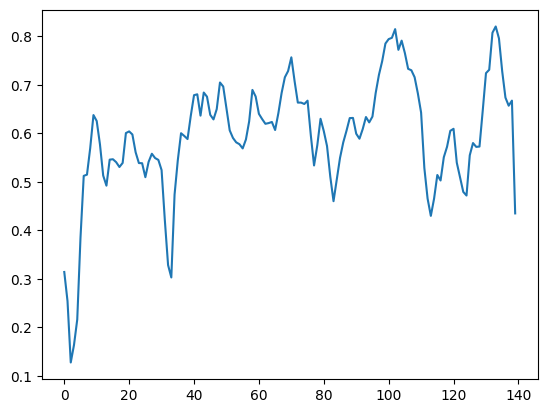

In [15]:
# 正常データの可視化
plt.plot(np.arange(140), normal_x_train_scaled[0])
plt.show()

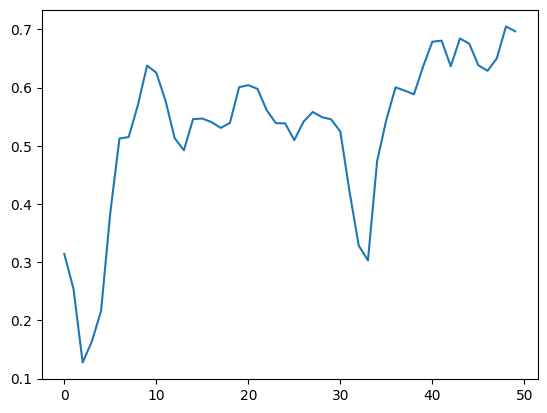

In [16]:
n=50
plt.plot(np.arange(n), normal_x_train_scaled[0,0:n])

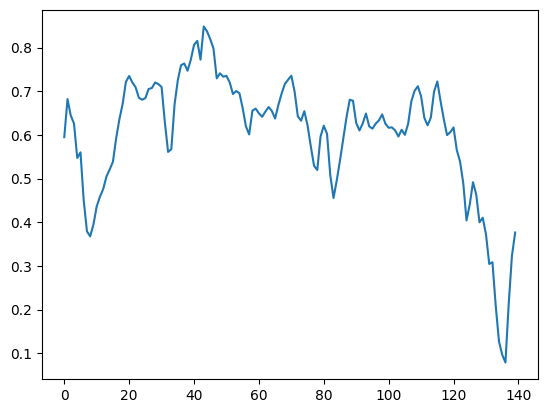

In [17]:
# 異常データの可視化
plt.plot(np.arange(140), anomaly_x_train_scaled[0])
plt.show()

In [18]:
d=0
# PyTorch の Tensor 型へ変換
#normal_train = torch.tensor(normal_x_train_scaled, dtype=torch.float32)
#normal_train = torch.tensor(x_train[t_train_bool].values, dtype=torch.float32)  # Use .values to get the NumPy array

# x_train[t_train_bool].values の各データの最小値を0にシフトしたものを normal_x_train_shifted とする
#normal_x_train_shifted = x_train[t_train_bool].values - np.min(x_train[t_train_bool].values, axis=1, keepdims=True)
normal_x_train_shifted = x_train[t_train_bool].values - np.mean(x_train[t_train_bool].values, axis=1, keepdims=True)+d

normal_train = torch.tensor(normal_x_train_shifted, dtype=torch.float32)

#normal_val = torch.tensor(normal_x_val_scaled, dtype=torch.float32)
#normal_x_val_shifted = x_val[t_val_bool].values - np.min(x_val[t_val_bool].values, axis=1, keepdims=True)
normal_x_val_shifted = x_val[t_val_bool].values - np.mean(x_val[t_val_bool].values, axis=1, keepdims=True)+d

normal_val = torch.tensor(normal_x_val_shifted, dtype=torch.float32)

# 異常データの系列が再現できるかを検証するため、異常データの変換も行っておく
#anomaly_train = torch.tensor(anomaly_x_train_scaled, dtype=torch.float32)
#anomaly_train= torch.tensor(x_train[~t_train_bool].values, dtype=torch.float32)  # Use .values to get the NumPy array

#anomaly_x_train_shifted = x_train[~t_train_bool].values - np.min(x_train[~t_train_bool].values, axis=1, keepdims=True)
anomaly_x_train_shifted = x_train[~t_train_bool].values - np.mean(x_train[~t_train_bool].values, axis=1, keepdims=True)+d


anomaly_train = torch.tensor(anomaly_x_train_shifted, dtype=torch.float32)

#anomaly_val = torch.tensor(anomaly_x_val_scaled, dtype=torch.float32)
#anomaly_x_val_shifted = x_val[~t_val_bool].values - np.min(x_val[~t_val_bool].values, axis=1, keepdims=True)
anomaly_x_val_shifted = x_val[~t_val_bool].values - np.mean(x_val[~t_val_bool].values, axis=1, keepdims=True)+d

anomaly_val = torch.tensor(anomaly_x_val_shifted, dtype=torch.float32)


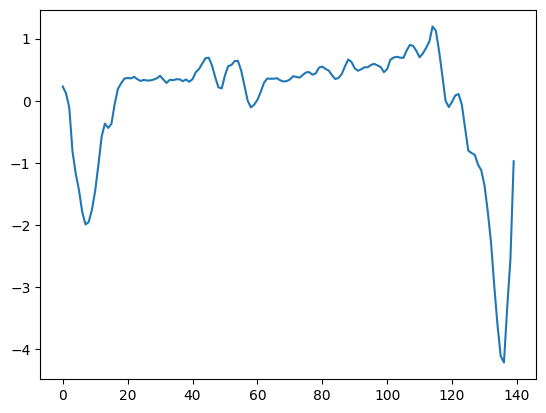

In [19]:
# 異常データの可視化
plt.plot(np.arange(140), anomaly_train[0])
plt.show()

In [20]:
train = torch.utils.data.TensorDataset(normal_train, normal_train)
val = torch.utils.data.TensorDataset(normal_val, normal_val)


In [21]:

# Calculate the mean of normal_train
#mean_normal_train = torch.mean(normal_train, dim=0)  # Calculate mean across data points

# Create the training dataset using the mean as the target
#train = torch.utils.data.TensorDataset(normal_train, mean_normal_train.repeat(normal_train.shape[0], 1))

# Similarly for validation dataset
#mean_normal_val = torch.mean(normal_val, dim=0)
#val = torch.utils.data.TensorDataset(normal_val, mean_normal_val.repeat(normal_val.shape[0], 1))


In [22]:
# バッチサイズの定義
batch_size = 512

In [23]:
# Data Loader を用意
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val, batch_size)

In [127]:
class Encoder(pl.LightningModule):
    def __init__(self, input_dim, encoding_dim, hidden_dim):
        super().__init__()

        self.fc1 = nn.Linear(input_dim, encoding_dim)
        self.fc2 = nn.Linear(encoding_dim, int(encoding_dim/2)) # エンコーディング層の次元数を減らす＝データを低次元に圧縮
        self.fc3 = nn.Linear(int(encoding_dim/2), hidden_dim)

    def forward(self, x):
        h = self.fc1(x)
        h = F.relu(h)
        h = self.fc2(h)
        h = F.relu(h)
        h = self.fc3(h)
        h = F.relu(h)
        return h

In [128]:

class Encoder(pl.LightningModule):
    def __init__(self, input_dim, encoding_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, encoding_dim)
        self.ln1 = nn.LayerNorm(encoding_dim)  # Layer Normalizationを追加
        self.fc2 = nn.Linear(encoding_dim, int(encoding_dim/2))
        self.ln2 = nn.LayerNorm(int(encoding_dim/2))  # Layer Normalizationを追加
        self.fc3 = nn.Linear(int(encoding_dim/2), hidden_dim)
        self.ln3 = nn.LayerNorm(hidden_dim)  # Layer Normalizationを追加

    def forward(self, x):
        h = self.fc1(x)
        h = self.ln1(h)  # Layer Normalizationを適用
        h = F.leaky_relu(h)  # LeakyReLUに変更
        h = self.fc2(h)
        h = self.ln2(h)  # Layer Normalizationを適用
        h = F.leaky_relu(h)  # LeakyReLUに変更
        h = self.fc3(h)
        h = self.ln3(h)  # Layer Normalizationを適用
        h = F.leaky_relu(h)  # LeakyReLUに変更
        return h

In [129]:
class Decoder(pl.LightningModule):
    def __init__(self, input_dim, encoding_dim, hidden_dim):
        super().__init__()

        self.fc1 = nn.Linear(hidden_dim, int(encoding_dim/2))
        self.fc2 = nn.Linear(int(encoding_dim/2), encoding_dim)
        self.fc3 = nn.Linear(encoding_dim, input_dim)

    def forward(self, x):
        h = self.fc1(x)
        h = F.relu(h)
        h = self.fc2(h)
        h = F.relu(h)
        h = self.fc3(h)
        # 最後の出力を0 ~ 1 におさめる
#        h = F.sigmoid(h)
        h = F.softplus(h)  # または h = torch.exp(h)
        return h

In [130]:
class Decoder(pl.LightningModule):
    def __init__(self, input_dim, encoding_dim, hidden_dim):
        super().__init__()

        self.fc1 = nn.Linear(hidden_dim, int(encoding_dim/2))
        self.fc2 = nn.Linear(int(encoding_dim/2), encoding_dim)
        self.fc3 = nn.Linear(encoding_dim, input_dim)

    def forward(self, x):
        h = self.fc1(x)
        h = F.relu(h)
        h = self.fc2(h)
        h = F.relu(h)
        h = self.fc3(h)
        # 最後の出力を0 ~ 1 に制限しないように変更
        # h = F.sigmoid(h)  <- Sigmoid関数を削除
        # 以下のいずれかの活性化関数を試してみてください
        h = h  # Linear関数 (活性化関数なし)
        # h = F.relu(h)  # ReLU関数
        # h = F.leaky_relu(h)  # LeakyReLU関数
        return h

In [131]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR  # Import StepLR

class AutoEncoder(pl.LightningModule):

    # 140 -> 32 -> 16 -> 8 -> 16 -> 32 -> 140 のネットワークを定義
    def __init__(self, input_dim=140, encoding_dim=32, hidden_dim=8):
        super().__init__()

        self.encoder = Encoder(input_dim, encoding_dim, hidden_dim)
        self.decoder = Decoder(input_dim, encoding_dim, hidden_dim)

    # 順伝播
    def forward(self, x):
        h = self.encoder(x)
        h = self.decoder(h)
        return h

    def training_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.mse_loss(y, t) # 注意：x と t は同じ値
        self.log('train_loss', loss, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.mse_loss(y, t)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.mse_loss(y, t)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2, weight_decay=1e-3) # 学習率とweight_decayを変更
        scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3) # ReduceLROnPlateauを使用
        return {
            'optimizer': optimizer,
            'lr_scheduler': scheduler,
            'monitor': 'val_loss'  # ReduceLROnPlateauで監視する指標を指定
        }

In [132]:
# GPU を含めた乱数のシードを固定
pl.seed_everything(0)

# 定義したクラスをインスタンス化
net = AutoEncoder()
net

INFO:lightning_fabric.utilities.seed:Seed set to 0


AutoEncoder(
  (encoder): Encoder(
    (fc1): Linear(in_features=140, out_features=32, bias=True)
    (ln1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (fc2): Linear(in_features=32, out_features=16, bias=True)
    (ln2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (fc3): Linear(in_features=16, out_features=8, bias=True)
    (ln3): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=8, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=32, bias=True)
    (fc3): Linear(in_features=32, out_features=140, bias=True)
  )
)

In [133]:
# 学習を行う Trainer
logger = CSVLogger(save_dir='logs', name='my_exp')
trainer = pl.Trainer(max_epochs=50, deterministic=True, logger=logger)

# 学習の実行
trainer.fit(net, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 5.3 K  | train
1 | decoder | Decoder | 5.3 K  | train
--------------------------------------------
10.6 K    Trainable params
0         Non-trainable params
10.6 K    Total params
0.042     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [134]:
# 結果を確認
filepaths = natsorted(glob('logs/my_exp/*'))
filepaths[-1]

'logs/my_exp/version_4'

In [135]:
log = pd.read_csv(f'{filepaths[-1]}/metrics.csv')

In [136]:
log = pd.read_csv(f'{filepaths[-1]}/metrics.csv')

logs/my_exp/version_4/metrics.csv


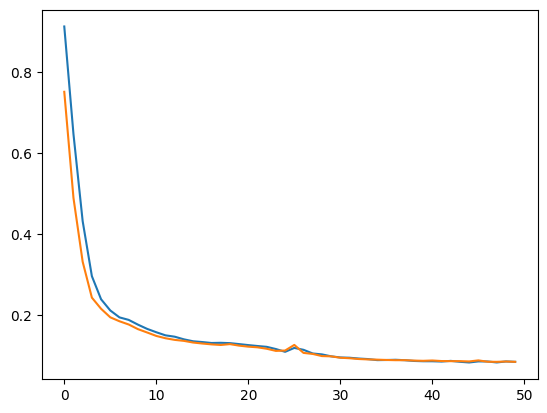

In [137]:
# loss
print(f'{filepaths[-1]}/metrics.csv')
log[['train_loss_epoch', 'epoch']].dropna(how='any', axis=0).reset_index()['train_loss_epoch'].plot();
log[['val_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['val_loss'].plot();

In [138]:
# 推論
net.eval() # 推論モード
net.cpu() # CPU での推論

AutoEncoder(
  (encoder): Encoder(
    (fc1): Linear(in_features=140, out_features=32, bias=True)
    (ln1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (fc2): Linear(in_features=32, out_features=16, bias=True)
    (ln2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (fc3): Linear(in_features=16, out_features=8, bias=True)
    (ln3): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=8, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=32, bias=True)
    (fc3): Linear(in_features=32, out_features=140, bias=True)
  )
)

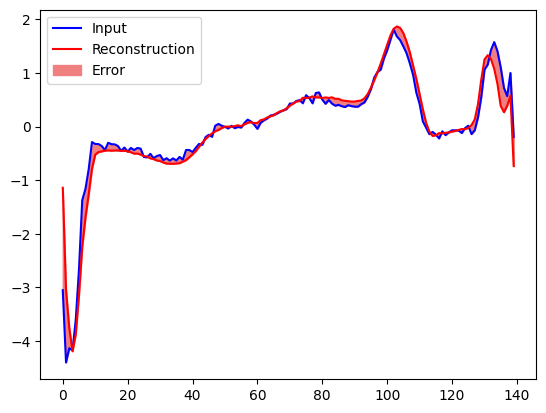

In [139]:
# 学習データの推論
# 勾配計算を行わない
decoded_data = net(normal_train).detach().numpy()

# 元データと推論データの可視化
plt.plot(normal_train[0], 'b') # 元データを青色で
plt.plot(decoded_data[0], 'r') # 再構築（復元）されたデータを赤色で
plt.fill_between(np.arange(140), normal_train[0], decoded_data[0], color='lightcoral') # 差分を塗りつぶし
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

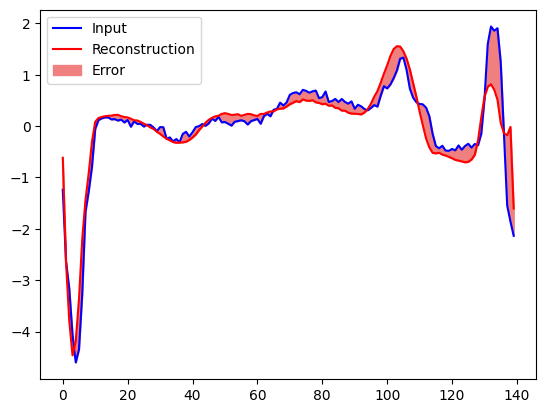

In [140]:

# 検証データの推論
decoded_data = net(normal_val).detach().numpy()

# 元データと推論データの可視化
plt.plot(normal_val[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), normal_val[0], decoded_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

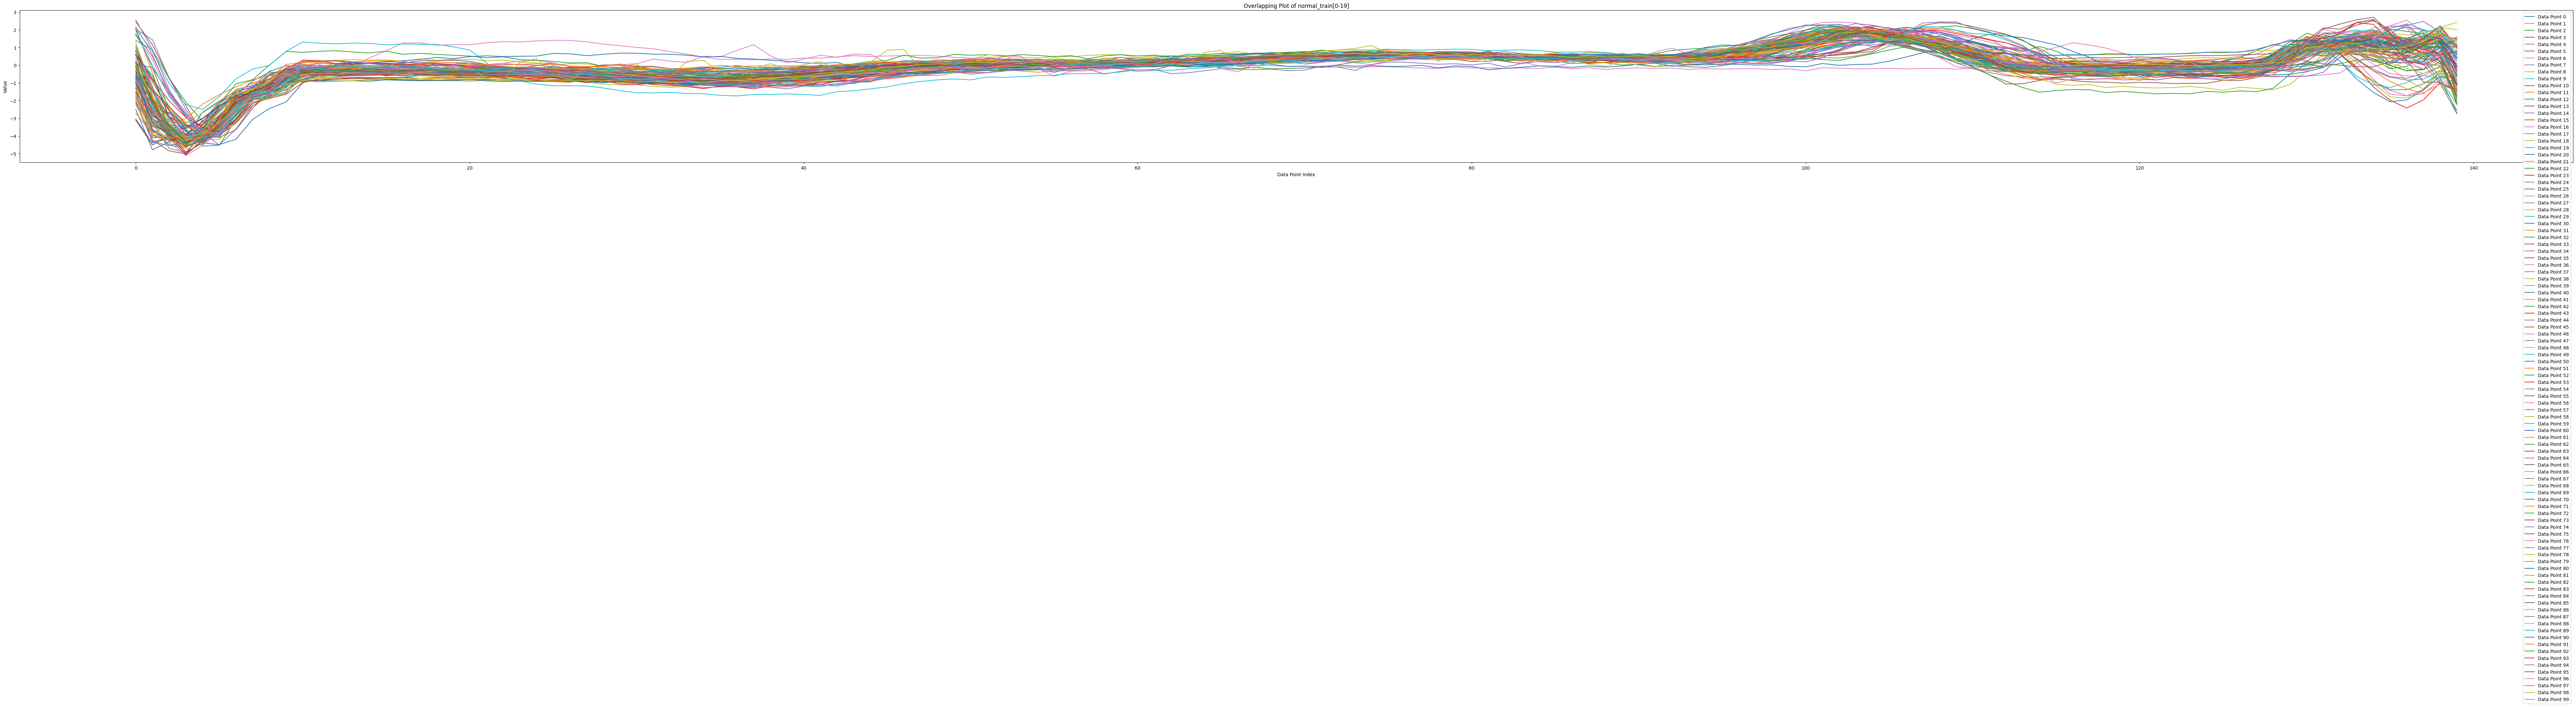

In [141]:
import matplotlib.pyplot as plt

# normal_train[0～9] を重ねてプロット
plt.figure(figsize=(100, 6))  # プロットサイズを調整

for i in range(100):
    plt.plot(normal_train[i], label=f'Data Point {i}')

plt.title('Overlapping Plot of normal_train[0-19]')
plt.xlabel('Data Point Index')
plt.ylabel('Value')
plt.legend()  # 凡例を表示
plt.show()

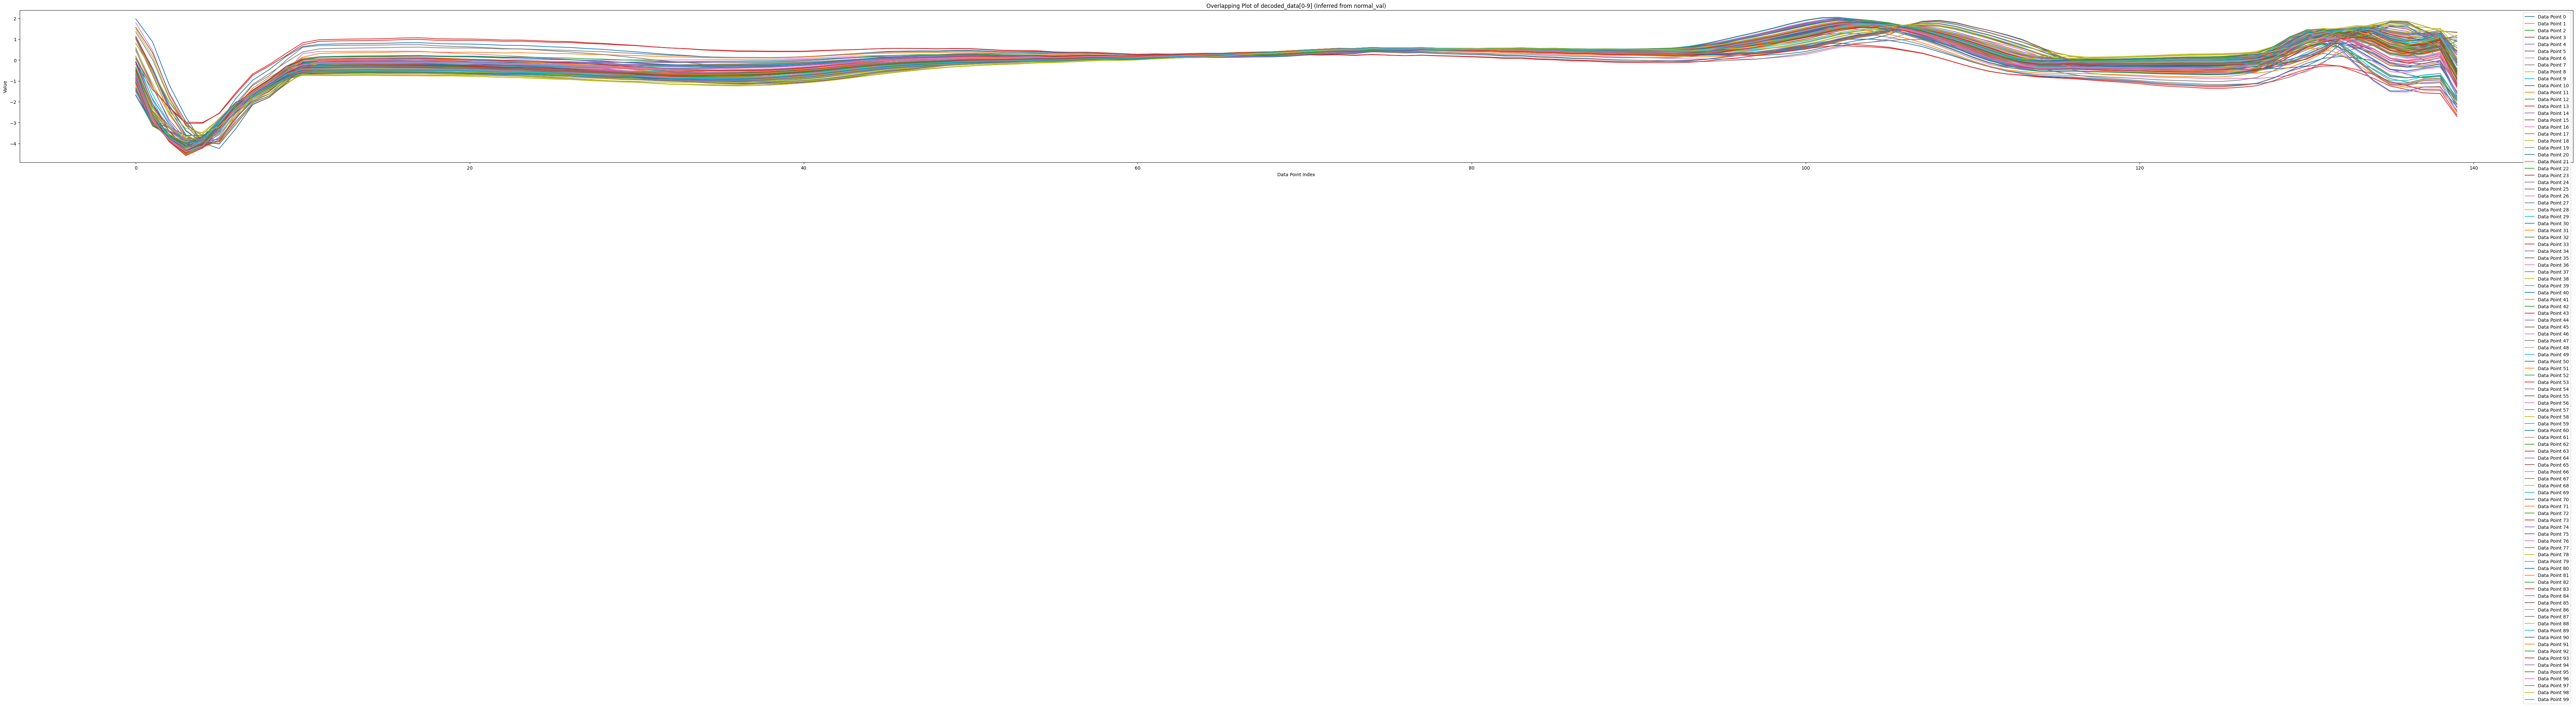

In [142]:
import matplotlib.pyplot as plt

# decoded_data[0～9] を重ねてプロット (normal_val から推論されたデータ)
plt.figure(figsize=(100, 6))  # プロットサイズを調整

# decoded_data は normal_val から推論されたデータであることを前提としています
decoded_data = net(normal_val).detach().numpy()

for i in range(100):
    plt.plot(decoded_data[i], label=f'Data Point {i}')

plt.title('Overlapping Plot of decoded_data[0-9] (Inferred from normal_val)')
plt.xlabel('Data Point Index')
plt.ylabel('Value')
plt.legend()  # 凡例を表示
plt.show()


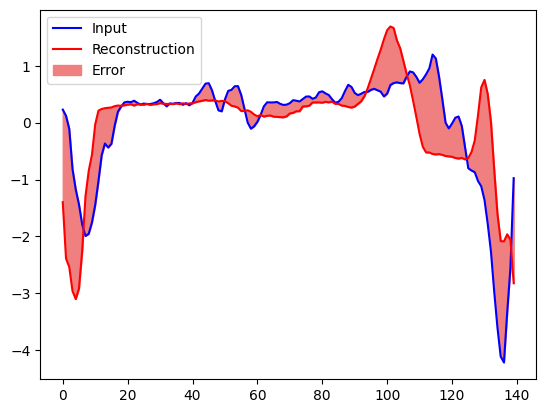

In [143]:
# 異常データの推論
decoded_data = net(anomaly_train).detach().numpy()

# 元データと推論データの可視化
plt.plot(anomaly_train[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), anomaly_train[0], decoded_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [144]:
# 推論
decoded_data = net(normal_train)

# 推論結果と予測結果の誤差を算出
loss = decoded_data - normal_train
#loss = decoded_data[:, 120:140] - normal_train[:, 120:140]
loss = (loss.detach().numpy()) ** 2 # 誤差の各要素を二乗＝大きな誤差により重いペナルティを与える
normal_loss = np.sum(loss, axis=1) # 誤差の総和

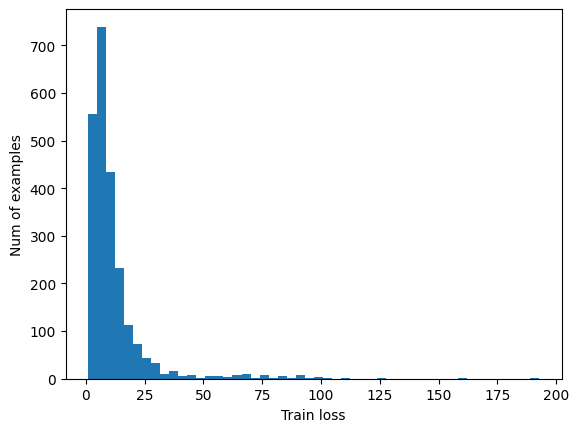

In [145]:
# 差分の可視化
plt.hist(normal_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("Num of examples") # データポイントの総数
plt.show()

In [170]:
#threshold = np.mean(normal_loss) + np.std(normal_loss)
threshold = np.mean(normal_loss) + np.std(normal_loss)*1.3
print("Threshold: ", threshold)

Threshold:  29.80848455429077


In [171]:
# 推論
decoded_data = net(anomaly_train)

# 推論結果と予測結果の誤差を算出
loss = decoded_data - anomaly_train
loss = (loss.detach().numpy()) ** 2
anomaly_loss = np.sum(loss, axis=1)

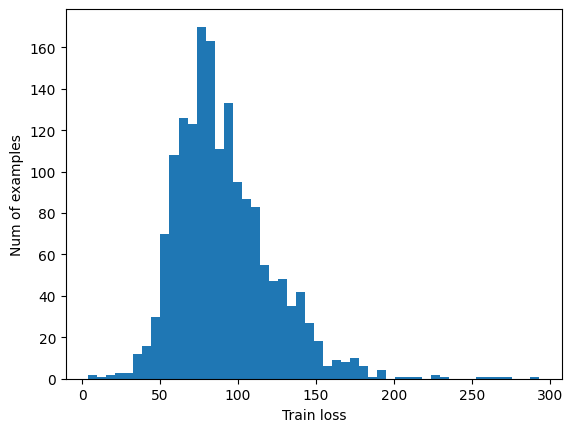

In [172]:
# 差分の可視化
plt.hist(anomaly_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("Num of examples")
plt.show()

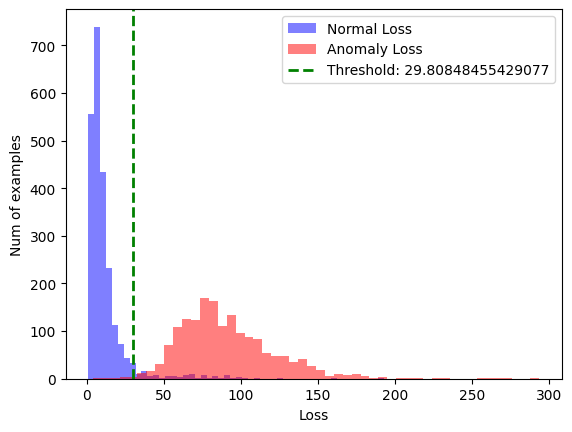

In [173]:
# ヒストグラムをまとめて表示

# ヒストグラムの描画
plt.hist(normal_loss, bins=50, alpha=0.5, label='Normal Loss', color='blue')
plt.hist(anomaly_loss, bins=50, alpha=0.5, label='Anomaly Loss', color='red')

# 閾値のラインを引く
plt.axvline(threshold, color='green', linestyle='dashed', linewidth=2, label=f'Threshold: {threshold}')

# 軸ラベルと凡例の設定
plt.xlabel("Loss")
plt.ylabel("Num of examples")
plt.legend()

# グラフの表示
plt.show()

In [174]:

normal_labels = np.zeros_like(normal_loss)  # 0 for normal
anomaly_labels = np.ones_like(anomaly_loss) # 1 for anomaly

all_data = np.concatenate([normal_loss, anomaly_loss])
all_labels = np.concatenate([normal_labels, anomaly_labels])


predictions = (all_data > threshold).astype(int) # 1 if above threshold (anomaly), 0 otherwise

accuracy = accuracy_score(all_labels, predictions)
precision = precision_score(all_labels, predictions)
recall = recall_score(all_labels, predictions)


print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.9672336168084043
Precision: 0.9323562570462233
Recall: 0.9933933933933934


In [175]:
# 異常検知を実施する関数
def predict(model, data, threshold):
    # モデルを使用して推論
    decoded_data = model(data)
    # 誤差の算出
    loss = decoded_data - data
    loss = (loss.detach().numpy()) ** 2
    loss = np.sum(loss, axis=1)
    # 誤差の値が閾値を下回るかどうかでラベルをふる
    res = np.array(loss < threshold)
    return res

# 結果を表示する関数
def print_stats(predictions, labels):
    print(f'Accuracy = {accuracy_score(labels, predictions)}')
    print(f'Precision = {precision_score(labels, predictions)}')
    print(f'Recall = {recall_score(labels, predictions)}')

In [176]:
predictions = predict(net, torch.tensor(x_val.values, dtype=torch.float32), threshold) # threshold は先程求めた閾値
print_stats(predictions, t_val)

Accuracy = 0.969
Precision = 0.9982046678635548
Recall = 0.9488054607508533


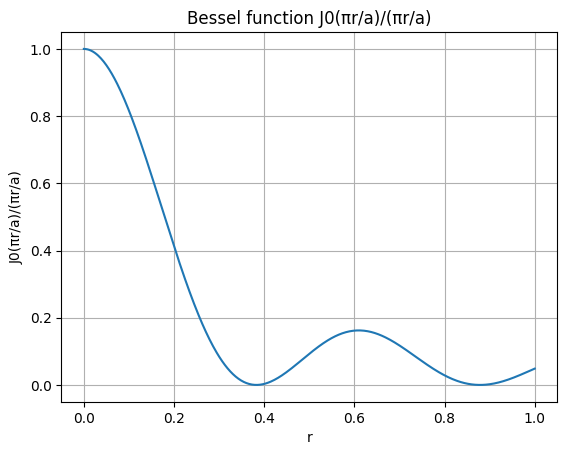

In [177]:
# prompt: ベッセル関数J0(πr/a)/(πr/a)のグラフ描画

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j0

# ベッセル関数J0(πr/a)/(πr/a)の計算
r = np.linspace(0, 1, 500)  # rの範囲を調整
a = 0.5  # aの値を調整
y = j0(np.pi * r / a) **2

# グラフの描画
plt.plot(r, y)
plt.xlabel("r")
plt.ylabel("J0(πr/a)/(πr/a)")
plt.title("Bessel function J0(πr/a)/(πr/a)")
plt.grid(True)
plt.show()
